# 1 - Importation et nettoyage des données

Commençons par une présentation du sujet que l'on a choisi de traiter.

Le dataset est celui des courses de taxi à New York : http://chriswhong.com/open-data/foil_nyc_taxi/. Il contient environ les données de 170 millions de courses effectuées en 2013. 

Concrètement, le dataset est composé des fichiers suivants :
- 12 fichiers concernant les informations sur les variables de paiements (prix total, pourboire, péages, etc.) des courses par mois (fichier 1 -> janvier, etc.)
- 12 fichiers concernant les informations sur les variables de 'course' (heure, localisation, nombre de passagers, etc.), aussi réparties par mois.

L'ensemble des données représente 45,2 Go de données brutes. Nous avons choisi de ne pas faire nos analyses sur le jeu complet. Néanmoins, le dernier notebook propose quelques utilisation basiques de cytoolz afin de calculer quelques résultats simples.

Au cours des notebooks qui vont suivre, nous allons chercher à comprendre quelle variables influent sur la valeur du pourboire laissée en fin de courses, dans le but de construire ensuite des modèles de prédiction portant sur cette variable. Voici la liste des notebooks :
- 1) Importation et nettoyage des données
- 2) Quelques explorations et représentation graphique
- 3) Tests statistiques sur la significativité de certaines variables
- 4) Construction d'un modèle de classification (pourboire=0 vs pourboire>0)
- 5) Construction d'un modèle de regression (prédiction de la valeur exacte du pourboire)
- 6) Utilisation de cytoolz

In [27]:
%matplotlib inline

On importe la librairie qu'on va utiliser

In [28]:
import pandas

Parmis les 45 Go de données disponibles, on a préalablement tiré aléatoirement, sans remise, 0.5% des courses. Ce nouveau dataset est enregistré au format csv sous le nom 'trip_small.csv'. Cette étape n'est pas décrite dans ce rapport (il s'agit simplement d'un join entre les deux fichiers disponibles par mois, puis d'un tirage aléatoire).

On charge ensuite le fichier 'trip_small.csv' à l'aide de la commande suivante :

In [29]:
directory = 'C:\\Users\\Alexis\\Google Drive\\Documents\\ENSAE\\Semestre 1\\Projet python\\'
#directory = '/Users/pierredesmet/Documents/Documents Word/Etudes/UTT/ENSAE/Python pour le Data Scientist/'
#importation des data des trips    
with open(directory+'trip_small.csv', 'r', encoding='utf-8') as f :
    df = pandas.read_csv(f, sep=',', 
                         header=0,
                         index_col=False,
                         na_filter=True
                         )
    df['pickup_datetime'] = pandas.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    df['dropoff_datetime'] = pandas.to_datetime(df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

On affiche une partie du dataframe pour vérifier que l'importation s'est bien passée

In [30]:
df.head()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,...,rate_code,store_and_fwd_flag,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_lattitude,dropoff_longitude,dropoff_lattitude
0,D5367E940A20B9D2550BF7CF7AE01681,5B34A2589D1D2106FC0C47564A4833F0,CMT,2013-01-08 12:50:22,CSH,7.5,0.0,0.5,0.0,0.0,...,1,N,2013-01-08 12:58:39,2,496,1.10,-73.952026,40.766479,-73.966827,40.759968
1,69F42CD1BA72F0F090E85F299C7B6301,65BABDDBC94F4C1AA996FA693E4D4F57,VTS,2013-01-13 11:09:00,CRD,5.0,0.0,0.5,1.0,0.0,...,1,NaN,2013-01-13 11:13:00,1,240,0.57,-73.999786,40.728497,-73.994179,40.724926
2,F0C1205FC27DF89D8C9F8DC2F324E36C,FAA39BEB7D7159DCB3DCAC56EED0CEA7,VTS,2013-01-13 10:28:00,CSH,4.5,0.0,0.5,0.0,0.0,...,1,NaN,2013-01-13 10:31:00,5,180,0.61,-73.978935,40.784966,-73.971329,40.786163
3,3112FC4E5C14054B8A5DB00037572C70,9F959826431402B410E0B8FA23160AFE,VTS,2013-01-13 10:32:00,CSH,5.5,0.0,0.5,0.0,0.0,...,1,NaN,2013-01-13 10:35:00,5,180,1.28,-73.960541,40.762005,-73.950432,40.776211
4,83D724FB9372FAA2691477C69BA5960D,13965C53790515B884992824857D6ABE,VTS,2013-01-13 10:09:00,CSH,20.0,0.0,0.5,0.0,0.0,...,1,NaN,2013-01-13 10:31:00,1,1320,5.56,-73.955032,40.820316,-73.965187,40.759563


On regarde aussi le nombre de trajets :

In [31]:
df.shape

(865886, 21)

Ce résultat est cohérent avec les 170 millions de trajets annoncés sur le site. En effet, 0.5% de 170 millions font bien :

In [32]:
0.005*170000000

850000.0

On peut maintenant effectuer le nettoyage des données. Pour chaque colonne, on va vérifier qu'elle ne contient pas de valeurs abberante.
Commençons par supprimer de suite les variables qui ne serviront pas : 
- `store_and_fwd_flag` : variable qui indique si le taxi était connecté à un serveur lors de l'envoi des données
- `mta_tax` : variable qui vaut toujours 0.50$ (c'est une taxe à NYC)
- `rate_code` : indique si c'est le taux standard ou un autre taux. Dans les faits, cette variable vaut (quasiment) toujours le taux standard

Supprimons les.

In [33]:
df = df.drop(['store_and_fwd_flag', 'mta_tax', 'rate_code'], axis=1)

Commençons avec '`medallion`' : on sait que c'est un 'identifiant' donné par la mairie de NYC pris par un chauffeur en début de tournée et rendu en fin de tournée. Il y en a environ 13 000. Vérifions le. (source : https://en.wikipedia.org/wiki/Taxicabs_of_New_York_City)

In [34]:
len(df.groupby(['medallion']).medallion.nunique())

13491

C'est cohérent. Faisons de même avec `hack_license`. La hack licence est censée représenter l'identifiant d'un chauffeur de taxi (chaque chauffeur possède un identifiant fixe).

In [35]:
len(df.groupby(['hack_license']).hack_license.nunique())

38513

Il y aurait environ 38 000 taximen à NYC. Cette valeur est en adéquation avec le nombre de medallion distribués par la ville (trois chauffeurs pour un medallion).
On continue avec `vendor_id` et `payment_type`: 
- Il existe deux applications tierces concurrente de paiement : CMT et VTS
- Il existe 5 modes de paiements : 
  1. Credit card 
  2. Cash 
  3. No charge
  4. Dispute
  5. Unknown 

In [36]:
df.groupby(['vendor_id']).vendor_id.count()

vendor_id
CMT    433947
VTS    431939
Name: vendor_id, dtype: int64

In [37]:
df.groupby(['payment_type']).payment_type.count()

payment_type
CRD    466716
CSH    395425
DIS       631
NOC      2051
UNK      1063
Name: payment_type, dtype: int64

C'est bon aussi.
Les variables `pickup_datetime` et `dropoff_datetime` représentent la date de début et de fin de la course. Vérifions qu'elle sont bien du type date :

In [38]:
print(df.pickup_datetime.dtype)
print(df.dropoff_datetime.dtype)

datetime64[ns]
datetime64[ns]


C'est bien le cas.
Poursuivons avec `passenger_count`. Cette variable doit être un entier, strictement positif, et pas trop grand (au-delà de 10 on peut se poser des questions...). Observons les valeurs prises par cette variable.

In [39]:
df.groupby(['passenger_count']).passenger_count.count()

passenger_count
0        23
1    610131
2    117412
3     36544
4     17921
5     50003
6     33852
Name: passenger_count, dtype: int64

On a 23 courses sans passagers ! Ajoutons donc une règle qui ne garde que les courses qui sont strictement positives

In [40]:
df = df[df['passenger_count'] >= 1]

Passons aux variables relatives aux caractéristiques de la course : `trip_distance` et `trip_time_in_secs`. Calculons les indicateurs usuels de dispersion :

In [41]:
df[['trip_time_in_secs', 'trip_distance']].describe()

,trip_time_in_secs,trip_distance
count,8.658630e+05,8.658630e+05
mean,7.932786e+02,4.736823e+00
std,1.304894e+04,1.719473e+03
min,-1.000000e+01,0.000000e+00
25%,3.600000e+02,1.040000e+00
50%,6.000000e+02,1.800000e+00
75%,9.600000e+02,3.200000e+00
max,4.294948e+06,1.600000e+06


On remarque qu'il existe des valeurs incohérentes : négatives ou beaucoup trop grandes ! Observons le à l'aide d'histogrammes.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C118FDE7B8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001C11DACE208>]], dtype=object)

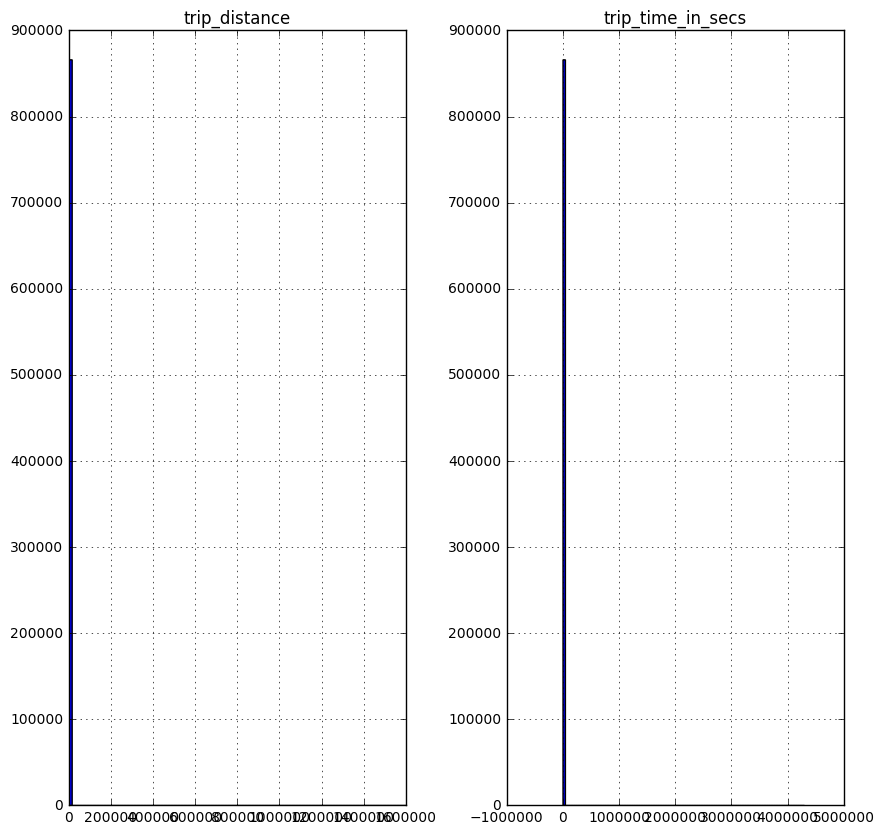

In [42]:
df.hist(column=['trip_time_in_secs','trip_distance'],bins=100, figsize=(10,10))

On exclue donc les valeurs extrèmes (plus petites que le quantile 0.001 et plus grandes que le quantile 0.999)

In [43]:
q1 = df['trip_time_in_secs'].quantile(q=0.001)
q2 = df['trip_time_in_secs'].quantile(q=0.999)
df = df[(df['trip_time_in_secs'] < q2) & (df['trip_time_in_secs'] > q1 )]
      
q1 = df['trip_distance'].quantile(q=0.001)
q2 = df['trip_distance'].quantile(q=0.999)
df = df[(df['trip_distance'] < q2) & (df['trip_distance'] > q1 )]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C123AF66D8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001C1275F9B70>]], dtype=object)

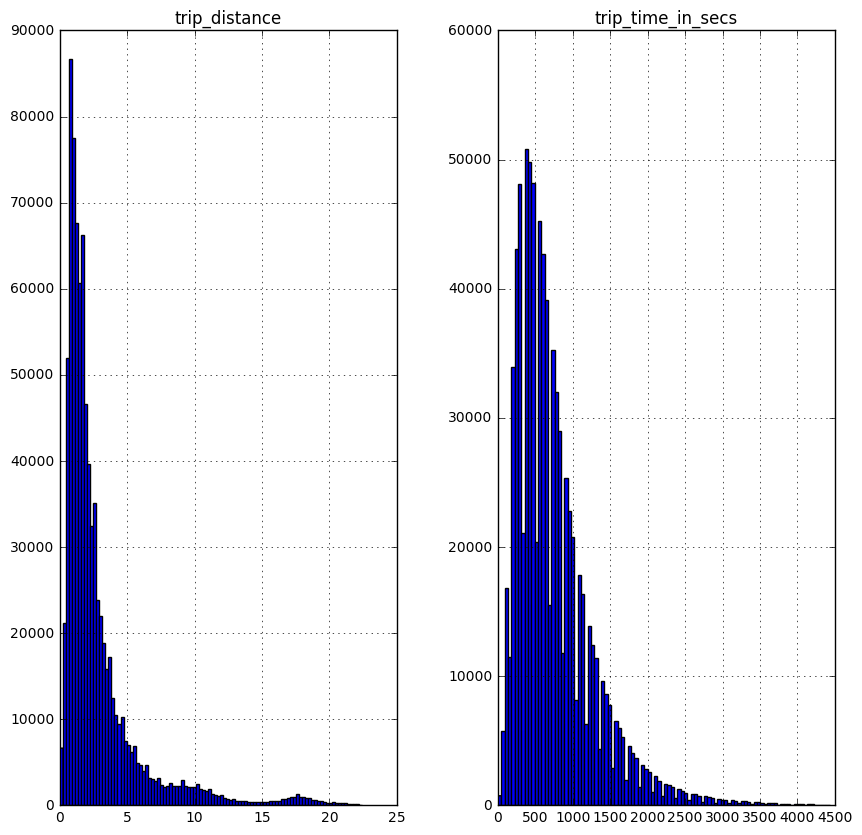

In [44]:
df.hist(column=['trip_time_in_secs','trip_distance'], bins=100, figsize=(10,10))

On procède de même avec les variables relatives au tarif de la course : `fare_amount`, `tip_amount`, `tolls_amount`, `total_amount`.

In [45]:
df[['fare_amount', 'tip_amount', 'tolls_amount', 'total_amount']].describe()

,fare_amount,tip_amount,tolls_amount,total_amount
count,857868.000000,857868.000000,857868.000000,857868.000000
mean,12.171089,1.347701,0.237525,14.576754
std,9.333800,2.079283,1.153394,11.290599
min,-73.500000,0.000000,0.000000,-74.000000
25%,6.500000,0.000000,0.000000,8.000000
50%,9.500000,1.000000,0.000000,11.000000
75%,14.000000,2.000000,0.000000,16.500000
max,247.000000,200.000000,23.350000,278.250000


On remarque déjà que la colonne `fare_amount` et `total_amount` possèdent des valeurs négatives.
De plus, les valeurs extrêmes, bien que probables (un pourboire de 200$ !), sont peut être un peu trop élevées. 
Affichons les histogrammes correspondants pour en être sûr.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C129D10FD0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001C119E32EB8>]], dtype=object)

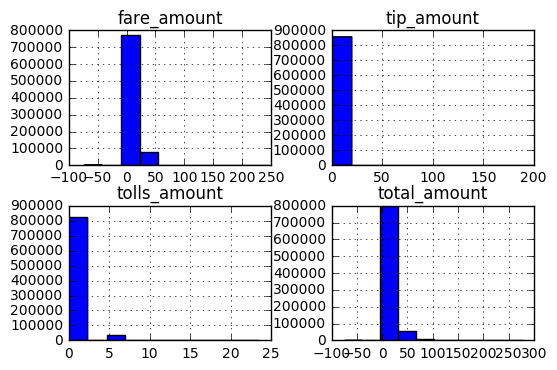

In [46]:
df.hist(column=['fare_amount', 'tip_amount', 'tolls_amount', 'total_amount'])

La variable `total_amount` étant la somme des trois précédente (aux taxes et surcharges près), on va filtrer sur celle-ci et sur `fare_amount` (pour être sûr de ne pas considérer des courses de valeur nulle), en utilisant les quantiles 0.001 et 0.999 comme précédement :

In [47]:
q1_tot = df['total_amount'].quantile(q=0.001)
q2_tot = df['total_amount'].quantile(q=0.999)

q1_fare = df['fare_amount'].quantile(q=0.001)
q2_fare = df['fare_amount'].quantile(q=0.999)

df = df[(df['total_amount'] < q2_tot) & (df['total_amount'] > q1_tot )]
df = df[(df['fare_amount'] < q2_fare) & (df['fare_amount'] > q1_fare )]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C119F03898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001C11A064048>]], dtype=object)

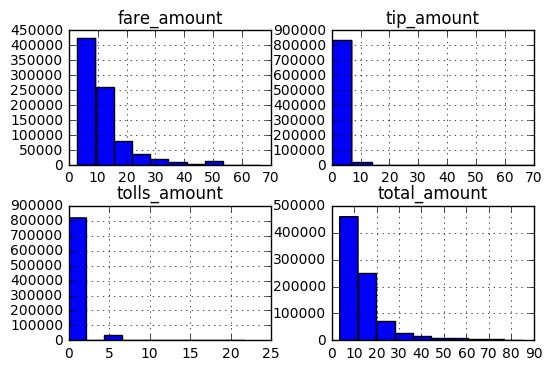

In [48]:
df.hist(column=['fare_amount', 'tip_amount', 'tolls_amount', 'total_amount'])

Ces distributions sont davantage acceptables.

On vérifie qu'il n'existe plus de courses "nulles" (i.e. avec un `fare_amount` nul) : 

In [49]:
df[['fare_amount', 'tip_amount', 'tolls_amount', 'total_amount']].describe()

,fare_amount,tip_amount,tolls_amount,total_amount
count,854443.000000,854443.000000,854443.000000,854443.000000
mean,12.115621,1.337566,0.226860,14.501715
std,9.041614,1.993140,1.094811,10.897330
min,3.000000,0.000000,0.000000,3.600000
25%,6.500000,0.000000,0.000000,8.000000
50%,9.500000,1.000000,0.000000,11.000000
75%,14.000000,2.000000,0.000000,16.500000
max,66.000000,70.000000,21.830000,85.000000


Enfin, on fait de même avec les variables de position. Pour celles-ci, il faut prendre des quantiles un peu plus stricts car elles comportent davantage de valeurs aberrantes :

In [50]:
q1 = df['pickup_longitude'].quantile(q=0.02)
q2 = df['pickup_longitude'].quantile(q=0.98)
df = df[(df['pickup_longitude'] < q2) & (df['pickup_longitude'] > q1 )]
      
q1 = df['pickup_lattitude'].quantile(q=0.02)
q2 = df['pickup_lattitude'].quantile(q=0.98)
df = df[(df['pickup_lattitude'] < q2) & (df['pickup_lattitude'] > q1 )]

q1 = df['dropoff_longitude'].quantile(q=0.02)
q2 = df['dropoff_longitude'].quantile(q=0.98)
df = df[(df['dropoff_longitude'] < q2) & (df['dropoff_longitude'] > q1 )]
      
q1 = df['dropoff_lattitude'].quantile(q=0.02)
q2 = df['dropoff_lattitude'].quantile(q=0.98)
df = df[(df['dropoff_lattitude'] < q2) & (df['dropoff_lattitude'] > q1 )]

In [51]:
df[['pickup_longitude', 'pickup_lattitude', 'dropoff_longitude', 'dropoff_lattitude']].describe()

,pickup_longitude,pickup_lattitude,dropoff_longitude,dropoff_lattitude
count,725673.000000,725673.000000,725673.000000,725673.000000
mean,-73.978524,40.752709,-73.978193,40.752967
std,0.023007,0.020255,0.020829,0.021592
min,-74.010193,40.684475,-74.011116,40.689156
25%,-73.992020,40.738960,-73.991432,40.738949
50%,-73.982262,40.754093,-73.981331,40.754406
75%,-73.969963,40.767113,-73.968506,40.767246
max,-73.792603,40.799881,-73.870461,40.806084


Voici donc le dataframe de base qui sera utilisé dans les prochains notebooks. 
**Remarque :** une implémentation de toutes ces étapes est écrite dans un fichier .py à part, qui sera appelé en début de chacun des notebooks suivants.

On note qu'on est passé de 865 886 courses à 725673, soit une perte de 140213 entrées, ie. une suppression de 16% des données. Cette valeur assez importante est du au grand nombre de valeur abérrante des variables de position (elles comptent pour 15% des données supprimées !)

In [57]:
df.shape

(725673, 20)

In [56]:
100*(865886-725673)/865886

16.193009241401292

Pour finir, on modifie les données portant sur la date et l'heure des trajets. En effet, la connaissance de l'heure exacte à la seconde près n'a en réalité que peu d'importance et va complexifier l'analyse. On va donc extraire de cette colonne (à savoir `pickup_datetime`) uniquement l'information qui semble pertinente : 
- la trajet a t-il eu lieu le jour ou la nuit ? On définit jour = (heure >= 8 a.m. et heure <= 8 p.m)
- quel jour de la semaine le trajet a t-il eu lieu ? (lundi, mardi, etc.)

In [54]:
def arrondi_nuit_jour(dt): 
    if(dt.hour >= 8 and dt.hour <= 20):
        return 'jour'
    return 'nuit'
    
def jour_semaine(dt):
    return dt.strftime('%A')

# On créé les nouvelles colonnes correspondantes
df['nuit_jour'] = df['pickup_datetime'].apply(arrondi_nuit_jour)
df['jour_semaine'] = df['pickup_datetime'].apply(jour_semaine)

Finalement, nous affichons `df` afin de contrôler qu'aucun nouveau problème n'est survenu :

In [55]:
df.head()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_lattitude,dropoff_longitude,dropoff_lattitude,nuit_jour,jour_semaine
0,D5367E940A20B9D2550BF7CF7AE01681,5B34A2589D1D2106FC0C47564A4833F0,CMT,2013-01-08 12:50:22,CSH,7.5,0.0,0.0,0.0,8.0,2013-01-08 12:58:39,2,496,1.10,-73.952026,40.766479,-73.966827,40.759968,jour,Tuesday
1,69F42CD1BA72F0F090E85F299C7B6301,65BABDDBC94F4C1AA996FA693E4D4F57,VTS,2013-01-13 11:09:00,CRD,5.0,0.0,1.0,0.0,6.5,2013-01-13 11:13:00,1,240,0.57,-73.999786,40.728497,-73.994179,40.724926,jour,Sunday
2,F0C1205FC27DF89D8C9F8DC2F324E36C,FAA39BEB7D7159DCB3DCAC56EED0CEA7,VTS,2013-01-13 10:28:00,CSH,4.5,0.0,0.0,0.0,5.0,2013-01-13 10:31:00,5,180,0.61,-73.978935,40.784966,-73.971329,40.786163,jour,Sunday
3,3112FC4E5C14054B8A5DB00037572C70,9F959826431402B410E0B8FA23160AFE,VTS,2013-01-13 10:32:00,CSH,5.5,0.0,0.0,0.0,6.0,2013-01-13 10:35:00,5,180,1.28,-73.960541,40.762005,-73.950432,40.776211,jour,Sunday
5,C852FCF8AFF847126AF8A109DE44BB1F,DFF8F13106E8C8C3773DE379678334E3,VTS,2013-01-13 06:28:00,CSH,8.0,0.0,0.0,0.0,8.5,2013-01-13 06:36:00,1,480,1.75,-73.986214,40.726437,-73.978065,40.745602,nuit,Sunday
